Classification of text documents using sparse features

In [1]:
from time import time 

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space"
]

def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6

def load_dataset(verbose=False, remove=()):
    """load and vectorize the 20 newspaper datasets"""

    data_train = fetch_20newsgroups(
        subset = "train",
        categories= categories,
        shuffle = True,
        random_state = 42,
        remove = remove
    )

    data_test = fetch_20newsgroups(
        subset = "test",
        categories=categories,
        shuffle = True,
        random_state=42,
        remove = remove
    )

    target_names = data_train.target_names

    y_train, y_test = data_train.target, data_test.target

    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, 
        max_df=0.5,
        min_df=5,
        stop_words="english"
    )

    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time()- t0

    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names_out()

    if verbose:
        # compute size of data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb: .2f}MB (training set)"
        )

        print(
            f"{len(data_test.data)} documents - {data_test_size_mb: .2f}MB (test set)"
        )

        print(f"{len(target_names)} categories")

        print(
            f"vectorize training done in {duration_train: .3f}s"
            f" at {data_train_size_mb/ duration_train: .3f} MB/s"
        )

        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")

        print(
            f"vectorize testing done in {duration_test:.3f}s"
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )

        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_test, y_train, y_test, feature_names, target_names


Analysis of a bag-of-words document classifier

In [2]:
X_train, X_test, y_train , y_test, feature_names , target_names = load_dataset(
    verbose=True
)

2034 documents -  3.98MB (training set)
1353 documents -  2.87MB (test set)
4 categories
vectorize training done in  0.705s at  5.644 MB/s
n_samples: 2034, n_features: 7831
vectorize testing done in 0.398sat 7.197MB/s
n_samples: 1353, n_features: 7831


In [3]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol = 1e-2, solver = "sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

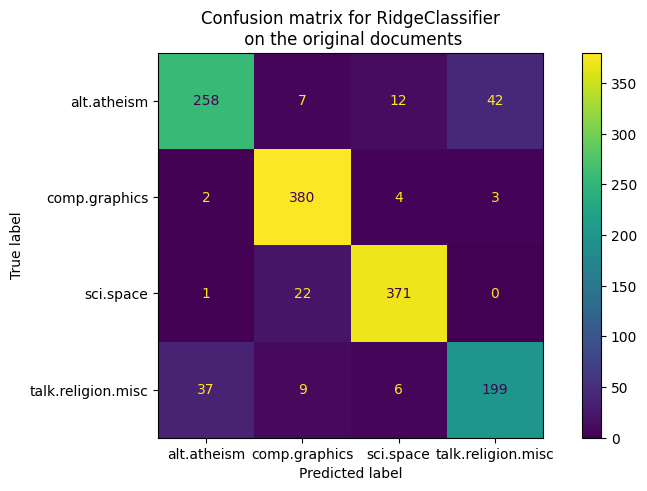

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig , ax = plt.subplots(figsize=(10,5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion matrix for {clf.__class__.__name__}\n on the original documents"
)

how this classifier makes its decisions by looking at the words with the highest average feature effects:

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


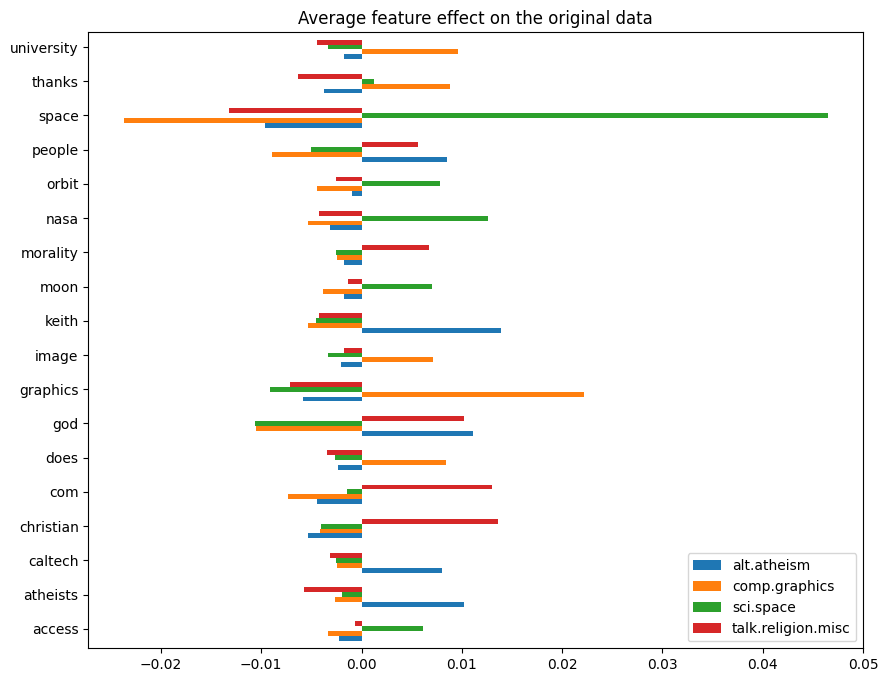

In [8]:
import numpy as np
import pandas as pd


def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")